In [ ]:
# Train TEdetection Model for Named Entity Recognition 
based model TEdetection_distiBERT_mLM_V2

In [1]:
model_name = "TEdetection_distiBERT_NER_V2"

## Load and Preprocess data

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  1 18:45:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
!pip install datasets transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import transformers
print(transformers.__version__)

2022-06-08 16:42:07.033611: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4.19.2


In [3]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import shelve
from datetime import datetime
import matplotlib.pyplot as plt

In [5]:

results = shelve.open(os.path.join("..", "data", "prep_trainvalidationtest_1"),'r')
df = results["chunks"]
tok = results["tokenize_table"]
results.close

<bound method Shelf.close of <shelve.DbfilenameShelf object at 0x14e54a357e80>>

In [6]:
df.head(2)

,origin,chunk,set,tokens,token_ids,attention_masks,labels
0,100.fasta,1,test,"[mcl00578, mcl00294, mcl01096, mcl01000, mcl01...","[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,100.fasta,2,test,"[mcl01236, mcl00376, mcl04030, mcl00368, mcl01...","[61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


##eliminate all chunks with only one token

without context an attention mechanism is useless

In [7]:
# get length of each chunk
l = []
for row in list(df["attention_masks"]):
  l.append(sum(row))
df["length"] = l

In [8]:
df = df[df["length"] > 1]

In [9]:
print("number of chunks:", df.shape[0])
print("number of unique tokens in the data: ", len(tok.keys()))
print("length of each chunk in the data: ", len(df["token_ids"].iloc[0]))
print("length of shortest chunk :", df["length"].min())

number of chunks: 234404
number of unique tokens in the data:  32634
length of each chunk in the data:  150
length of shortest chunk : 2


## Shuffle data

In [10]:
np.random.seed(4711)
df = df.sample(frac=1).reset_index(drop=True)

## extract training and validation data for NER task

In [11]:
df_training_tkn = df[df["set"] == "training"]["token_ids"]
training_tokens = np.array([x for x in df_training_tkn.tolist()])
df_training_lbs = df[df["set"] == "training"]["labels"]
training_labels = np.array([x for x in df_training_lbs.tolist()])
df_training_att = df[df["set"] == "training"]["attention_masks"]
training_attention_masks = np.array([x for x in df_training_att.tolist()])

df_validation_tkn = df[df["set"] == "validation"]["token_ids"]
validation_tokens = np.array([x for x in df_validation_tkn.tolist()])
df_validation_lbs = df[df["set"] == "validation"]["labels"]
validation_labels = np.array([x for x in df_validation_lbs.tolist()])
df_validation_att = df[df["set"] == "validation"]["attention_masks"]
validation_attention_masks = np.array([x for x in df_validation_att.tolist()])

##Check the prepared data


*   df                        : dataframe with all input data (training, validation, test)
*  
*   training_tokens           : np_array with training tokens
*   training_labels           : np_array with training labels (named entities)
*   training_attention_masks  : np_array with training attention masks
*  
*   validation_tokens           : np_array with validation tokens
*   validation_labels           : np_array with validation labels (named entities)
*   validation_attention_masks  : np_array with validation attention masks




In [12]:
validation_tokens[110][44:62]

array([4466, 4465, 4464, 4463, 4462, 4461, 4460, 4459, 4458, 4457, 4456,
       4455, 4454, 4453, 4452, 4451, 4450, 4449])

In [13]:
validation_labels[110][44:62]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
validation_attention_masks[110][44:62]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Convert the data to dictionaries


    there are three possibilities you can use to gather all the input Tensors in the first positional argument :

    a single Tensor with input_ids only and nothing else: model(inputs_ids)
    a list of varying length with one or several input Tensors IN THE ORDER given in the docstring: model([input_ids, attention_mask])
    a dictionary with one or several input Tensors associated to the input names given in the docstring: model({"input_ids": input_ids})

    we will work with a dictionary


In [16]:
# not used, training dict will be created in training loop, batch by batch (see below)

tf_train_dict = { 'input_ids': tf.convert_to_tensor(training_tokens), #[0:100]),
            'attention_mask': tf.convert_to_tensor(training_attention_masks), #[0:100]),
           'labels': tf.convert_to_tensor(training_labels) #[0:100])
         }

2022-06-08 16:43:27.903495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 16:43:39.463991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29880 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2022-06-08 16:43:39.465763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29880 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2022-06-08 16:43:39.467486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

In [26]:
training_tokens[0]

array([ 4029,  4028,  4027,  4026,  4025,  4024,  4023,  4022, 13911,
        8283,  4021,  4020,  4019,  4018,  4017,  4016,  4015,  4014,
        4013,  4012,  4011,  4010,  5971,  4009,  4008,  4007,  4006,
        4004,  4003,  4002,  5970, 10236, 10237,  3998, 10238,  2016,
       10239, 10240, 10241, 10242, 10243,  5969,  3997,  3996,  5968,
        3995,  3994,  3993,  5967,  3992,  3991,  3990,  3989,  3988,
        3983,  3982,  3981,  3979,  3978,  3977, 10244,  3976,  3975,
        3974,  3973,  3972,  3971,  3970,  3969,  3968,  3967,  3966,
        3965,  3964,  3963,  3962,  3961, 14666,  3960,  3959,  3958,
        3957,  3956, 10245, 10246, 10247, 10248, 10249, 12552, 10250,
       10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259,
       10260, 10261,  3955,  3949,  9125,  5913,  6973,  5914,  5915,
        5916,  5917,  6974,  3947,  3946,  3945,  3942,  5676,  5677,
        5678,  5679,  3941,  3940,  3939,  3938,  3937,  3936,  3935,
        3934,  3933,

In [17]:
tf_val_dict = { 'input_ids': tf.convert_to_tensor(validation_tokens), #[0:20]),
           'attention_mask': tf.convert_to_tensor(validation_attention_masks), #[0:20]),
           'labels': tf.convert_to_tensor(validation_labels), #[0:20])
         }

## Functions for saving model-weights

    # Restore the weights
    model.load_weights(path)

    # Evaluate the model
    loss, acc = model.evaluate(test_images, test_labels, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [18]:
def save_my_model_weights():
    d = str(datetime.now())
    checkpoint_name = model_name + "-" + d[0:10] + "-" + d[11:13] + "-" + d[14:16]
    checkpoint_dir = os.path.join("drive", "MyDrive", "Project TE", "models", checkpoint_name)
    model.save_weights(checkpoint_dir)
    return

## Load the pretrained model
    our pretrained model is based on DistilBERT and was trained as a masked Language Model 


In [19]:
from transformers import TFAutoModelForTokenClassification
  
#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = TFAutoModelForTokenClassification.from_pretrained("models/MLM_3")

Some layers from the model checkpoint at models/MLM_3 were not used when initializing TFDistilBertForTokenClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at models/MLM_3 and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.summary()

Model: "tf_distil_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 67715328  
 nLayer)                                                         
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 67,716,866
Trainable params: 67,716,866
Non-trainable params: 0
_________________________________________________________________


## Compile the model
configure the training hyperparameters and call compile() and fit(). We’ll use a learning rate schedule with some warmup to improve the stability of training. 

In [21]:
# with tensorflow

from transformers import create_optimizer

num_train_steps = len(training_tokens) #[0:100])   ## change this when training with the full data
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=1_000,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [24]:
history = model.fit(tf_train_dict, validation_data=tf_val_dict, epochs=1, batch_size = 32, verbose=1)

6532/6532 [==============================] - 1088s 165ms/step - loss: 0.0141 - val_loss: 0.0037


In [25]:
model.save_pretrained("models/NER_1") 

## Train the model

In [23]:
loss = []
val_loss = []

In [29]:
t_p = {   # training parameters
        "nb_all_train_rows": len(training_tokens), # rows in training data

        "mini_batch_size": 32, # rows per mini_batch (tensorflow parameter)
        "batch_size": 512, # mini_batches per batch (inner loop)
        "step_size": 1, # batches per step (print progress)
        "epochs": 1, # how many times full data will be processed (outer loop)

        "start_row": 0, # for full data training: start_row = 0
                          # for partial data training: early_stop = x (only from x. rows in data will be used for training)
        "early_stop": 200, # for full data training: early_stop = nb_all_train_rows
                           # for partial data training: early_stop = x (only x rows in data will be used for training)
}
t_p["early_stop"] = t_p["nb_all_train_rows"]
t_p

{'batch_size': 512,
 'early_stop': 209018,
 'epochs': 1,
 'mini_batch_size': 32,
 'nb_all_train_rows': 209018,
 'start_row': 0,
 'step_size': 1}

In [30]:
#from transformers.keras_callbacks import PushToHubCallback
#callback = PushToHubCallback(output_dir="codeparrot-ds", tokenizer=tokenizer)

steps = (t_p["early_stop"] - t_p["start_row"]) / t_p["mini_batch_size"] / t_p["batch_size"] / t_p["step_size"]
if steps % 1 > 0:
    steps = steps + 1
steps = int(steps)

for epoch in range(0,t_p["epochs"]):
    step = 0
    for start in range(t_p["start_row"], min(t_p["early_stop"]+t_p["start_row"], t_p["nb_all_train_rows"]) , t_p["mini_batch_size"] * t_p["batch_size"]):
        if step % t_p["step_size"] == 0:
            print("epoch", epoch+1, "/", t_p["epochs"], ", step", (step // t_p["step_size"]) + 1, "/", steps)
        step = step + 1    
        end = min(start + t_p["mini_batch_size"] * t_p["batch_size"], min(t_p["early_stop"]+t_p["start_row"], t_p["nb_all_train_rows"])) 
        #print (start, "/", end)
        mini_batch = { 'input_ids': tf.convert_to_tensor(training_tokens[start: end]),
                      'attention_mask': tf.convert_to_tensor(training_attention_masks[start: end]),
                      'labels': tf.convert_to_tensor(training_labels[start: end])
         }

        history = model.fit(mini_batch, validation_data=tf_val_dict, epochs=1, batch_size = t_p["mini_batch_size"], verbose=1) #, callbacks=[callback])
        loss.extend(list(history.history['loss']))
        val_loss.extend(list(history.history['val_loss']))

    save_my_model_weights() # save after each epoch

print("--------------------------- end ---------------------------------")

epoch 1 / 1 , step 1 / 13
512/512 [==============================] - 209s 388ms/step - loss: 0.0821 - val_loss: 0.0206
epoch 1 / 1 , step 2 / 13
512/512 [==============================] - 197s 385ms/step - loss: 0.0133 - val_loss: 0.0078
epoch 1 / 1 , step 3 / 13
512/512 [==============================] - 196s 384ms/step - loss: 0.0076 - val_loss: 0.0059
epoch 1 / 1 , step 4 / 13
512/512 [==============================] - 197s 384ms/step - loss: 0.0064 - val_loss: 0.0051
epoch 1 / 1 , step 5 / 13
512/512 [==============================] - 197s 385ms/step - loss: 0.0056 - val_loss: 0.0044
epoch 1 / 1 , step 6 / 13
512/512 [==============================] - 197s 384ms/step - loss: 0.0046 - val_loss: 0.0040
epoch 1 / 1 , step 7 / 13
512/512 [==============================] - 197s 385ms/step - loss: 0.0048 - val_loss: 0.0040
epoch 1 / 1 , step 8 / 13
512/512 [==============================] - 197s 385ms/step - loss: 0.0042 - val_loss: 0.0038
epoch 1 / 1 , step 9 / 13
512/512 [=============

####Plot training and validation loss per step

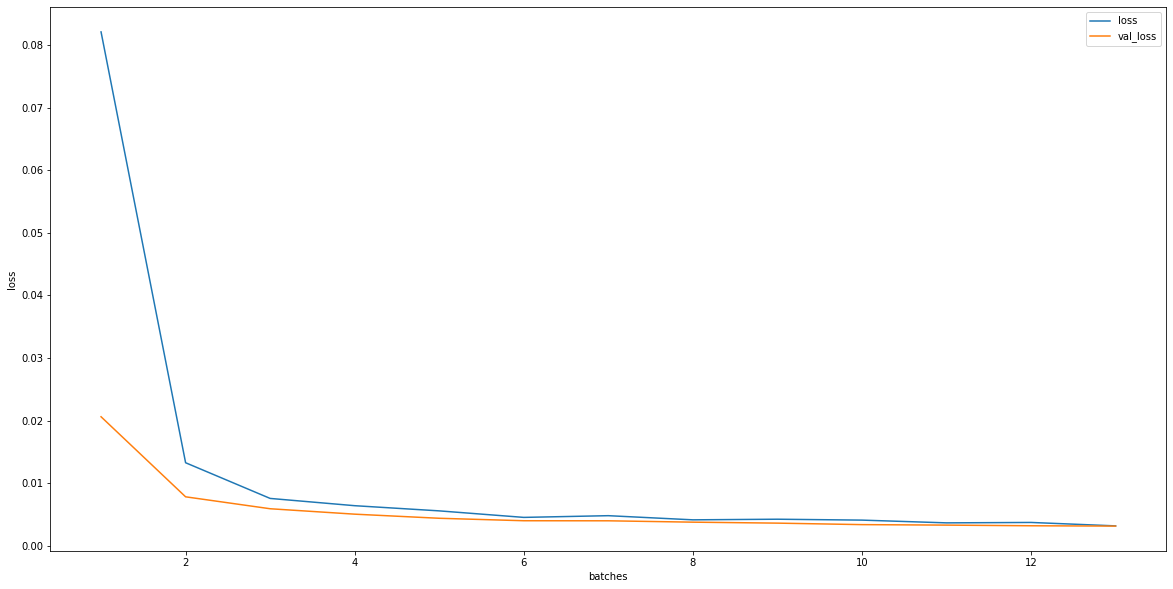

In [31]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(range(1, len(loss)+1),loss)
plt.plot(range(1, len(val_loss)+1),val_loss)
plt.ylabel('loss')
plt.xlabel('batches')
plt.legend(['loss', 'val_loss'])
plt.show()

## Get an output from is NER model

In [ ]:
def get_prediction(i, predictions):
    probs = tf.nn.softmax(predictions[0, i])
    result = tf.math.top_k(probs, k=2)
    pred = [result.indices.numpy(), result.values.numpy()]

    return pred

####Restore model
  run this only if necessary

In [ ]:
# Restore the model

checkpoint_name = "train_NER_M_V1-2022-05-31-11-38" # copy paste checkpoint name 
checkpoint_dir = os.path.join("drive", "MyDrive", "Project TE", "models", ".", checkpoint_name)
model.load_weights(checkpoint_dir)

#### Define input: Select a single chunk input from data

In [ ]:
test_element = 110     #750      #1300#1000#110
input = validation_tokens[test_element]
target = validation_labels[test_element]

#### Predict with the pretrained model

In [ ]:
outputs = model(input)

#### Evaluate the result

In [ ]:
i = 0
pred_arr = np.zeros(150)
for x in input:
    pred_arr[i] = get_prediction(i, outputs[0])[0][0]
    i = i+1
print("prediction:", list(pred_arr.astype(int)))
print("target    :",list(target))

prediction: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
target    : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Log in to huggingface

from huggingface_hub import notebook_login

notebook_login()

In [32]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


#### Push the model to hub

In [33]:
from transformers import AutoModel

# Push the model to your namespace with the name model_name and have a local clone in the
# *model_name* folder.
model.push_to_hub(model_name, use_auth_token="...")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='TEdetection_distiBERT_NER_V2' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:676: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/FritzOS/TEdetection_distiBERT_NER_V2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/258M [00:00<?, ?B/s]

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/FritzOS/TEdetection_distiBERT_NER_V2
   407c166..401e342  main -> main



'https://huggingface.co/FritzOS/TEdetection_distiBERT_NER_V2/commit/401e342793a2bb3f59629b290297313ef2433cf9'